## Домашнее задание. Урок 5. RNN
### Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

**Содержание**
* [Загрузка данных](#41)
* [Визуализация данных](#42)
* [Обработка данных](#43)
* [Создание RNN модели](#44)
* [Анализ оптимальной модели](#45)
* [Визуализация данных](#46)
* [Вывод](#47)

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

<a id="41"></a>
### Загрузка данных

In [19]:
data = pd.read_csv('airline-passengers.csv')
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<a id="42"></a>
### Визуализация данных

<AxesSubplot:>

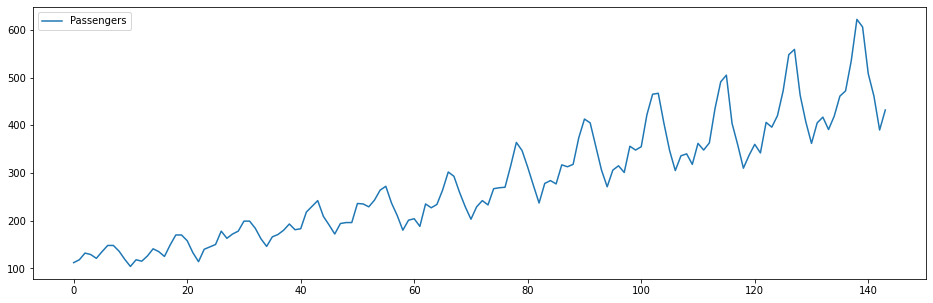

In [37]:
data.plot(figsize=(16, 5))

<AxesSubplot:>

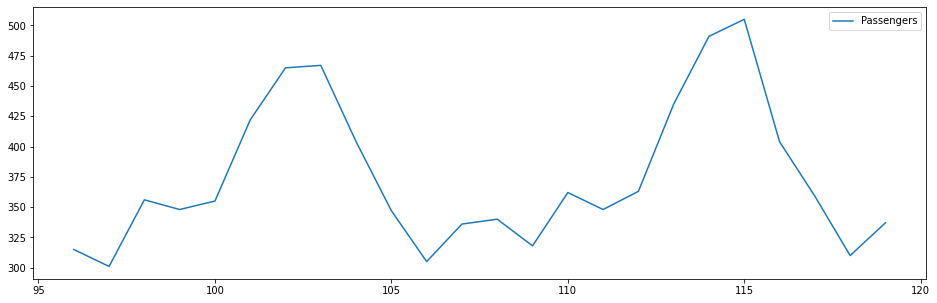

In [35]:
data.iloc[96:120].plot(figsize=(16, 5))

#### Вывод
> Данные имеют ярко выраженную сезонность, а также общую тенденцию увеличения среднего потока

<a id="43"></a>
### Обработка данных
* изменение размерности
* адаптация типов
* масштабирование
* разделение выборки
* создание набора для RNN

Изменение размерности

In [129]:
dataset = data.iloc[:, 1].values
dataset = dataset.reshape(-1, 1)
dataset = dataset.astype("float32")
dataset.shape

(144, 1)

Масштабирование

In [130]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

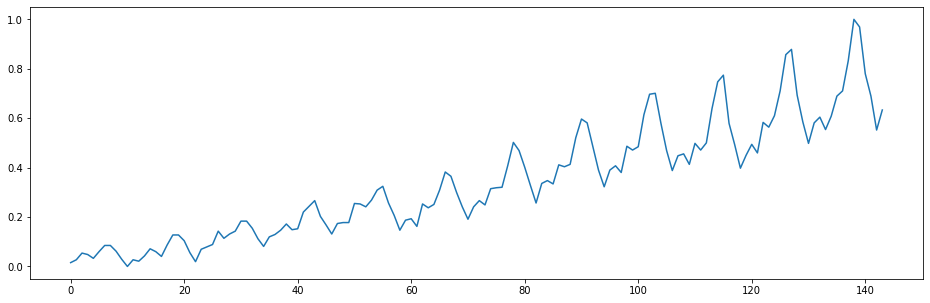

In [131]:
from matplotlib.pyplot import figure

figure(figsize=(16, 5))
plt.plot(dataset_scaled)
plt.show()

In [132]:
def split_time(dataset, percent=0.70):
    train_size = int(len(dataset) * percent)
    test_size = len(dataset) - train_size
    train = dataset_scaled[0:train_size, :]
    test = dataset_scaled[train_size:len(dataset), :]
    return train, test

In [133]:
train, test = split_time(dataset, percent=0.6)
print(f"train size: {len(train)}, test size: {len(test)} ")

train size: 86, test size: 58 


In [134]:
def create_time_dataset(ds, look_back=12):
    X = []
    Y = []
    for i in range(len(ds) - look_back - 1):
        a = ds[i:(i + look_back), 0]
        X.append(a)
        Y.append(ds[i + look_back, 0])
    return np.array(X), np.array(Y)

In [135]:
look_back = 10
trainX, trainY = create_time_dataset(train, look_back=look_back)
testX, testY = create_time_dataset(test, look_back=look_back)

In [136]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('shape of trainX: ', trainX.shape)
print('shape of testX: ', testX.shape)

shape of trainX:  (75, 10, 1)
shape of testX:  (47, 10, 1)


<a id="44"></a>
### Создание RNN модели

In [137]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


In [138]:
def build_model(input_shape=None, is_dropout=True, dropout_rate=0.2, is_simple=True):
    model = Sequential()

    model.add(SimpleRNN(units=100, activation='relu', return_sequences=True,
                        input_shape=input_shape))
    if is_dropout:
        model.add(Dropout(dropout_rate))

    if not is_simple:
        model.add(SimpleRNN(units=80, activation='relu', return_sequences=True))
        if is_dropout:
            model.add(Dropout(dropout_rate))

        model.add(SimpleRNN(units=50, activation='relu', return_sequences=True))
        if is_dropout:
            model.add(Dropout(dropout_rate))

        # Adding a fourth RNN layer and some Dropout regularisation
        model.add(SimpleRNN(units=30, activation='relu', return_sequences=True))
        if is_dropout:
            model.add(Dropout(dropout_rate))

    # Adding a fifth RNN layer and some Dropout regularisation
    model.add(SimpleRNN(units=20))
    if is_dropout:
        model.add(Dropout(dropout_rate))

    # Adding the output layer
    model.add(Dense(units=1))
    return model


In [139]:
result = []
for is_simple in [False, True]:
    for is_dropout in [False, True]:
        for dropout_rate in [0.1, 0.2, 0.3]:
            regressor = build_model(input_shape=(trainX.shape[1], 1))
            regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
            history = regressor.fit(trainX, trainY, epochs=250, batch_size=1000, verbose=0)
            result.append(
                [is_simple, is_dropout, dropout_rate, history.history['loss'][-1], history.history['mae'][-1]])
            print(
                f'is_simple:{is_simple}, is_dropout:{is_dropout}, dropout_rate:{dropout_rate}, loss:{history.history["loss"][-1]}, mae:{history.history["mae"][-1]}')

is_simple:False, is_dropout:False, dropout_rate:0.1, loss:0.0017472519539296627, mae:0.03267640992999077
is_simple:False, is_dropout:False, dropout_rate:0.2, loss:0.0021646120585501194, mae:0.03446469455957413
is_simple:False, is_dropout:False, dropout_rate:0.3, loss:0.00280535570345819, mae:0.039527520537376404
is_simple:False, is_dropout:True, dropout_rate:0.1, loss:0.001522672944702208, mae:0.027322450652718544
is_simple:False, is_dropout:True, dropout_rate:0.2, loss:0.0015034112147986889, mae:0.02971484884619713
is_simple:False, is_dropout:True, dropout_rate:0.3, loss:0.0012725024716928601, mae:0.028184210881590843
is_simple:True, is_dropout:False, dropout_rate:0.1, loss:0.0020019325893372297, mae:0.033291641622781754
is_simple:True, is_dropout:False, dropout_rate:0.2, loss:0.001958108739927411, mae:0.03331318870186806
is_simple:True, is_dropout:False, dropout_rate:0.3, loss:0.0030737160705029964, mae:0.03855077922344208
is_simple:True, is_dropout:True, dropout_rate:0.1, loss:0.001

In [140]:
res_df=pd.DataFrame(result, columns=['is_simple', 'is_dropout', 'dropout_rate','loss','mae'])
res_df.sort_values(by='loss')

,is_simple,is_dropout,dropout_rate,loss,mae
9,True,True,0.1,0.001087,0.025883
5,False,True,0.3,0.001273,0.028184
4,False,True,0.2,0.001503,0.029715
3,False,True,0.1,0.001523,0.027322
0,False,False,0.1,0.001747,0.032676
11,True,True,0.3,0.001844,0.034477
7,True,False,0.2,0.001958,0.033313
6,True,False,0.1,0.002002,0.033292
1,False,False,0.2,0.002165,0.034465
10,True,True,0.2,0.002730,0.036761


In [141]:
res_df.sort_values(by='mae')

,is_simple,is_dropout,dropout_rate,loss,mae
9,True,True,0.1,0.001087,0.025883
3,False,True,0.1,0.001523,0.027322
5,False,True,0.3,0.001273,0.028184
4,False,True,0.2,0.001503,0.029715
0,False,False,0.1,0.001747,0.032676
6,True,False,0.1,0.002002,0.033292
7,True,False,0.2,0.001958,0.033313
1,False,False,0.2,0.002165,0.034465
11,True,True,0.3,0.001844,0.034477
10,True,True,0.2,0.002730,0.036761


#### Вывод
> Минимальные потери (MSE) достигнуты в примере номер 9 - 0.001
> Так же в примере 9 достигнута минимальная абсолютная ошибка (MAE) - 0.026

<a id="45"></a>
### Анализ оптимальной модели
#### Предсказание значений, приведение к начальному масштабу, вычисление ошибки

In [142]:
build_model(input_shape=(trainX.shape[1], 1), is_simple=True, is_dropout=False)
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
regressor.fit(trainX, trainY, epochs=250, batch_size=1000, verbose=0)

In [143]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = regressor.predict(trainX)
testPredict = regressor.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.63 RMSE
Test Score: 29.15 RMSE


#### Вывод
Ошибка, обученной модели на тренировочных данных равна около 7. При разбросе данных от 100 до 350 это хороший результат. На тестовых данных ошибка гораздо выше - около 30. Однако при разбросе от 300 до 600 это также хорошо.

<a id="46"></a>
### Визуализация данных

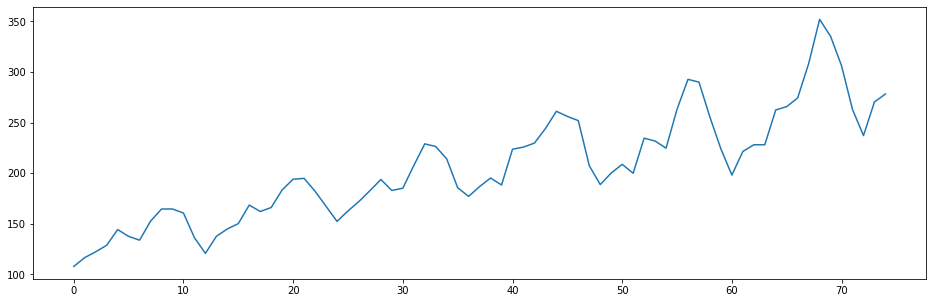

In [144]:
figure(figsize=(16, 5))
plt.plot(trainPredict)
plt.show()

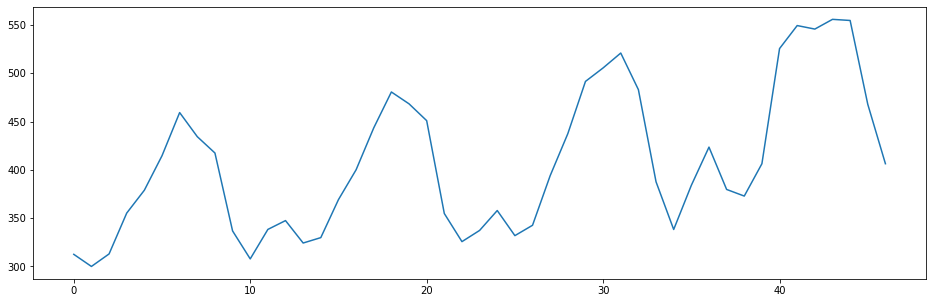

In [145]:
figure(figsize=(16, 5))
plt.plot(testPredict)
plt.show()

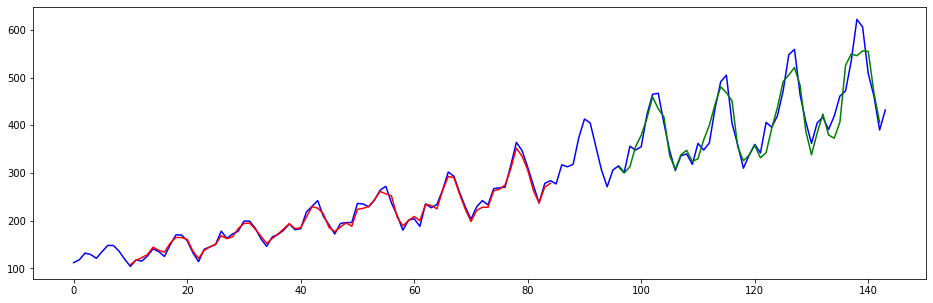

In [147]:
# сдвиг train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
# сдвиг предсказания на тесте
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

# визуализация исходных данных и предсказания
figure(figsize=(16, 5))
plt.plot(scaler.inverse_transform(dataset_scaled), color='b')
plt.plot(trainPredictPlot, color='r')
plt.plot(testPredictPlot, color='g')
plt.show()

<a id="47"></a>
### Вывод
> Построенная модель довольно точно предсказывает данные.
> Проведено исследование качества модели в зависимости от гиперпараметров:
* увеличение количества слоев
* добавление слоя Dropout
* увеличение коэффициента Dropout
> Дополнительные усложнения повлияли на модель отрицательно.
> Итоговая модель довольно быстро обучается и дает приемлемые результаты